## YouTube Trending Video Analysis & Prediction

### Joel Day, Caleb McCurdy, & Lane Whitmore

### The University of San Diego

#### ADS 508 - Data Science Cloud Computing

In [3]:
print("You may see error or warning messages, but that is okay. Proceed to the next cell.")
!pip --disable-pip-version-check -q  install transformers
!pip --disable-pip-version-check -q install pyathena
!pip --disable-pip-version-check -q install tensorflow
#!pip --disable-pip-version-check -q install torch==1.5.0
!pip --disable-pip-version-check -q install sagemaker-experiments==0.1.26

You may see error or warning messages, but that is okay. Proceed to the next cell.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sagemaker 2.144.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.1.0 which is incompatible.
sagemaker 2.144.0 requires PyYAML==5.4.1, but you have pyyaml 6.0 which is incompatible.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.144.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.1.0 which is i

In [4]:
# General imports
import pandas as pd
import numpy as np
import collections
import io
import os
import time
from smexperiments.trial import Trial
from smexperiments.experiment import Experiment
import uuid

# nlp processing imports
import string
import re
import nltk
from transformers import DistilBertTokenizer
from transformers import DistilBertModel


# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sagemaker imports
import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.debugger import ProfilerRule
from sagemaker.debugger import CollectionConfig
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.tensorflow import TensorFlow


# athena connection imports
from pyathena import connect
import boto3

#import torch
from sagemaker.pytorch import PyTorch
import tensorflow as tf
#import torch.nn as nn
#from torch.utils.data import TensorDataset, DataLoader

## Establishing Athena for SQL Queries

In [5]:
region = boto3.Session().region_name
role = get_execution_role()
sm = boto3.Session(region_name=region).client(service_name="sagemaker", region_name=region)

In [6]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()
print(bucket)

sagemaker-us-west-2-692349450615


Create folder within s3 bucket named youtubeStatistics

In [7]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [8]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

### Creating Database

In [9]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


### Creating Tables

#### CSV Tables

Currently, the tables below are still struggling to appropriately populate the tables. If the data type is anything but strings, the column becomes null for all values and the comma seperation is not consistent.

In [10]:
# set the names of folders holding different datasets
csv_folder = "csv"
json_folder = "json"

In [11]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [12]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,d1HUFPBWUh4,"Nous servons dans la cantine d'un lycée, les é...",2022-06-19T08:03:37Z,UCtxhwJ-6n4_C6ElALThD25Q,Mcfly et Carlito la chaîne secondaire,22,2022-06-21T00:00:00Z,[None],1684938,122259,0,1934,https://i.ytimg.com/vi/d1HUFPBWUh4/default.jpg,False,False,Après avoir perdu face à Maxime Gasteuil dans ...
1,DPJL488cfRw,Yunchan Lim 임윤찬 – RACHMANINOV Piano Concerto N...,2022-06-19T19:04:24Z,UC5Oz2fuXlILwEH4P96h2LLg,The Cliburn,10,2022-06-21T00:00:00Z,[None],1158892,36617,0,2125,https://i.ytimg.com/vi/DPJL488cfRw/default.jpg,False,False,"Final Round Concerto IIJune 17, 2022Bass Perfo..."
2,ASMMDYLry80,48hrs on Luxury Rocky Mountaineer Train - From...,2022-06-19T21:44:53Z,UC50xPFPma-nCS5GZpAFukpQ,Trek Trendy,19,2022-06-21T00:00:00Z,rocky mountaineer|rocky mountaineer train|luxu...,183186,7228,0,608,https://i.ytimg.com/vi/ASMMDYLry80/default.jpg,False,False,Head to https://squarespace.com/trektrendy to ...
3,Mbo4FzRy7k4,Everything in moderation! WHAT I EAT | Wellnes...,2022-06-20T04:48:12Z,UCAHufvd02viJSRdt3ojdPOg,Sarahs Day,22,2022-06-21T00:00:00Z,what I eat in a day|full day of eating|grocery...,178079,8414,0,331,https://i.ytimg.com/vi/Mbo4FzRy7k4/default.jpg,False,False,WELLNESS WEEK IS NOW LIVE!!https://www.sarahsd...
4,nEFcbKF4WfY,Return to Valoran City - Star Guardian 2022 | ...,2022-06-20T15:00:25Z,UC2t5bjwHdUX4vM2g8TRDq5g,League of Legends,20,2022-06-21T00:00:00Z,Star guardian|star guardian 2022|star guardian...,1000267,55422,0,3145,https://i.ytimg.com/vi/nEFcbKF4WfY/default.jpg,False,False,A new day is just over the horizon. Star Guard...
5,Ul_LSTpBVVA,Overpowered Weapons vs Custom Bosses in Minecraft,2022-06-19T15:30:03Z,UC_cvTMeip9po2hZdF3aBXrA,BeckBroJack,20,2022-06-21T00:00:00Z,minecraft|custom bosses|minecraft bosses|custo...,457641,38378,0,604,https://i.ytimg.com/vi/Ul_LSTpBVVA/default.jpg,False,False,Today I'm using Overpowered Weapons to beat Tw...
6,8kzU3gF92o0,ON DEVINE QUI EST SON MEC (Ft. Toomuchlucile &...,2022-06-19T15:30:01Z,UCXqnG7hbmGYDqC1iTNkVdew,Océane,22,2022-06-21T00:00:00Z,oceane|océane|océane les anges|oce.rthn|oce,729434,61449,0,2933,https://i.ytimg.com/vi/8kzU3gF92o0/default.jpg,False,False,"COUCOU GUYS!! Dans la vidéo d'aujourd'hui, on ..."
7,adBqwKLyZj4,I Completed The Wild Update Already..,2022-06-19T17:00:01Z,UCS5Oz6CHmeoF7vSad0qqXfw,DanTDM,20,2022-06-21T00:00:00Z,dantdm|dan tdm|gaming|video games|minecraft|funny,827033,45921,0,3312,https://i.ytimg.com/vi/adBqwKLyZj4/default.jpg,False,False,SUBSCRIBE OR THE WARDEN HUGS YOU TIGHTLYIn thi...
8,jQI5jD6ujXs,JEU EN VRAC - l'histoire de l'AMSTRAD,2022-06-19T16:00:32Z,UCCMxHHciWRBBouzk-PGzmtQ,Bazar du Grenier,20,2022-06-21T00:00:00Z,Jeu en vrac|jdg|joueur du grenier|bazar du gre...,604228,53875,0,1595,https://i.ytimg.com/vi/jQI5jD6ujXs/default.jpg,False,False,Cette vidéo est sponsorisée par Rhinoshield ! ...
9,D3qFfAEp9AU,Are They All The Same Motor Oil? Let's Settle ...,2022-06-19T16:49:32Z,UC2rzsm1Qi6N1X-wuOg_p0Ng,Project Farm,26,2022-06-21T00:00:00Z,project farm|motor oil review|are all motor oi...,533327,29212,0,4457,https://i.ytimg.com/vi/D3qFfAEp9AU/default.jpg,False,False,Let's find out if Pennzoil's motor oil (Pennzo...


In [13]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [14]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,UJtjoQ5TcVI,T-Pain & Kehlani - I Like Dat (Official Video),2021-06-24T20:00:11Z,UCwff7OoSHp3el6GqnSwcSdA,T Pain,10,2021-06-27T00:00:00Z,[None],1732985,44140,337,2533,https://i.ytimg.com/vi/UJtjoQ5TcVI/default.jpg,False,False,Listen to the single I Like Dat. Out now!Strea...
1,dxK3ZO4Qd0w,Ski Mask The Slump God - ADMIT IT (Official Au...,2021-06-25T04:00:38Z,UCdARoxad2UaIQPDy6fbz4Nw,Ski Mask The Slump God,22,2021-06-27T00:00:00Z,ski mask|the slump god|skee mask|skimask|ski m...,479294,53958,384,4077,https://i.ytimg.com/vi/dxK3ZO4Qd0w/default.jpg,False,False,Ski Mask The Slump God Presents: “Sin City The...
2,131bSyhnng0,The Cummins Mustang Gets Twin Turbos off Semi ...,2021-06-25T00:01:22Z,UChRlaISXbl2gECFAmDzxgzg,Westen Champlin,2,2021-06-27T00:00:00Z,[None],665060,41755,346,2372,https://i.ytimg.com/vi/131bSyhnng0/default.jpg,False,False,The Cummins Mustang Gets Twin Turbos off Semi ...
3,EvKFGJamaj4,What's Inside this Giant Stressball from Vat19...,2021-06-25T13:00:07Z,UCa64Z5S3s3FqlLI1jnSXzAw,Vat19 Shorts,22,2021-06-27T00:00:00Z,vat19|vat19 shorts,296125,21247,772,120,https://i.ytimg.com/vi/EvKFGJamaj4/default.jpg,False,False,Shop Vat19: https://www.vat19.com?adid=ytshort...
4,6g2BKuflJ4g,"Simone Biles nails double double dismount, wow...",2021-06-26T02:23:25Z,UCqZQlzSHbVJrwrn5XvzrzcA,NBC Sports,17,2021-06-27T00:00:00Z,Olympic Sports|Olympics|simone biles|gymnastic...,1560497,9619,207,931,https://i.ytimg.com/vi/6g2BKuflJ4g/default.jpg,False,False,Simone Biles did her thing on beam during Day ...
5,qFCeCPpfnhQ,WHY did I get my hopes up? - Windows 11 Announ...,2021-06-25T06:21:34Z,UCXuqSBlHAE6Xw-yeJA0Tunw,Linus Tech Tips,28,2021-06-27T00:00:00Z,microsoft|windows|windows 11|11|operating syst...,2510442,122605,2339,18178,https://i.ytimg.com/vi/qFCeCPpfnhQ/default.jpg,False,False,Get a Free Pair of Wireless Bluetooth Headphon...
6,mxG5UfyIYTk,Chase Atlantic - OHMAMI (Official Lyric Video),2021-06-25T04:00:11Z,UCpvCJWgUNwZArGtJ00kDS1A,CHASE ATLANTIC,10,2021-06-27T00:00:00Z,chase atlantic|ohmami|oh mami|chase atlantic o...,1167199,209347,715,21114,https://i.ytimg.com/vi/mxG5UfyIYTk/default.jpg,False,False,CHASE ATLANTIC – OHMAMIListen/Download single:...
7,kmk5vciFbek,Demi Lovato performs their greatest hits this ...,2021-06-26T00:07:19Z,UCZkURf9tDolFOeuw_4RD7XQ,Demi Lovato,24,2021-06-27T00:00:00Z,Pride|Pride 2021|YouTube Pride|YouTube Pride 2...,0,0,0,138,https://i.ytimg.com/vi/kmk5vciFbek/default.jpg,False,True,"On June 25, celebrate Pride 2021 with Demi Lov..."
8,rGKhjmSTYgE,NEW DRUGSTORE MAKEUP TESTED ... What's Good?,2021-06-24T19:00:09Z,UC4qk9TtGhBKCkoWz5qGJcGg,Tati,26,2021-06-27T00:00:00Z,YouTube|Beauty|Makeup|Tutorial|Review|blogger|...,907083,76893,816,7454,https://i.ytimg.com/vi/rGKhjmSTYgE/default.jpg,False,False,I'm going a throwback of What's New at The Dru...
9,U2chMEBdaCU,"Pancho Barraza & Grupo Firme, Eduin Caz - Mús...",2021-06-24T22:00:11Z,UC182E6DfqeGhPcyo-6N8xig,Pancho Barraza Oficial,10,2021-06-27T00:00:00Z,grupo firme|pancho barraza|banda ms|musica rom...,817118,30115,447,1084,https://i.ytimg.com/vi/U2chMEBdaCU/default.jpg,False,False,Titulo: Musica Romantica (Video Oficial)https:...


In [15]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/{csv_folder}/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [16]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 10", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,► Check out our Community tab for more stories...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,► Listen to our podcasts: https://www.ft.com/...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,NT9UKghTGLs,We did ILLEGAL Things While Driving,2022-10-19T17:24:12Z,UCNBbCOuAN1NZAuj0vPe_MkA,Car Throttle,2,2022-10-24T00:00:00Z,drink|driving|illegal|phone|texting|ringing|ca...,295429,10142,0,545,https://i.ytimg.com/vi/NT9UKghTGLs/default.jpg,False,False,This week Alex and Jack experiment with things...
5,xT3059r4-Qo,Sculptures Of Anything Goes,2022-10-20T10:49:10Z,UC8Yu1_yfN5qPh601Y4btsYw,Arctic Monkeys - Topic,10,2022-10-24T00:00:00Z,Arctic Monkeys|The Car|Sculptures Of Anything ...,214250,11378,0,0,https://i.ytimg.com/vi/xT3059r4-Qo/default.jpg,False,False,Provided to YouTube by DominoSculptures Of Any...
6,FcoVzLyFqNs,Norway's strongest man VS Rock Climbing,2022-10-19T16:01:16Z,UC_gSotrFVZ_PiAxo3fTQVuQ,Magnus Midtbø,17,2022-10-24T00:00:00Z,Climbing|Sondre Berg|Climb|calisthenics|Boulde...,2297349,42398,0,2000,https://i.ytimg.com/vi/FcoVzLyFqNs/default.jpg,False,False,Get Exclusive NordVPN deal here ➼ https://no...
7,NT14sw0_RRc,Prime Minister's Questions (PMQs) - 19 October...,2022-10-19T12:45:19Z,UCMasyWuE1P2AaEKw_FkGq9g,UK Parliament,25,2022-10-24T00:00:00Z,#PMQs,100610,889,0,0,https://i.ytimg.com/vi/NT14sw0_RRc/default.jpg,True,False,The British Sign Language (BSL) version is ava...
8,YBNcYxHJPLE,How the World’s Wealthiest People Travel,2022-10-19T16:01:35Z,UC9RM-iSvTu1uPJb8X5yp3EQ,Wendover Productions,27,2022-10-24T00:00:00Z,[None],1068842,33219,0,3083,https://i.ytimg.com/vi/YBNcYxHJPLE/default.jpg,False,False,Sign up for a CuriosityStream subscription and...
9,QPBz7p9Jh7M,Exploding 250 Pound Glitter Pumpkin!,2022-10-19T18:00:09Z,UC3v6sjWuPxtW36jQ-if4OuA,Imbrandonfarris,23,2022-10-24T00:00:00Z,[None],573190,30981,0,1189,https://i.ytimg.com/vi/QPBz7p9Jh7M/default.jpg,False,False,Kinda..


#### JSON Tables

In [17]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://{bucket}/youtubeStatistics/{json_folder}/usa/US_category_id_test.json';
"""

pd.read_sql(us_json_create, conn)

""


In [18]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


In [19]:
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,youtubedb


In [20]:
if db_name in db_show.values:
    ingest_create_athena_db_passed = True

In [21]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Exploratory Data Analysis

#### US American Gaming Exploration

Preparing the data for exploration by adjusting the necessary column types.

### Initial Preprocesssing and transformations to visualize the data properly

#### Data Import 

The data set below is created from the United States area where categoryid = 20 or 'Gaming' category on Youtube. As many of the creators under our companies umbrella do create 'Gaming' content, it is a key area for ViewBoost to focus in on. It also provides an opportunity to refine a robust deep learning neural network as there is still 37,000 records within the US Gaming segment. 

In [22]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,qcY9qy1SaL8,"I Survived 2,000 Days in HARDCORE Minecraft...",2021-10-23T12:15:11Z,UCFrVj6wBM42y3XuKCAj8n5A,SB737,20,2021-10-27T00:00:00Z,minecraft|gaming|sb737|sb minecraft|sb|let's p...,2163189,123429,1683,8435,https://i.ytimg.com/vi/qcY9qy1SaL8/default.jpg,False,False,"BUY 2,000 DAYS POSTER HERE: https://sb737.stor..."
1,8kVXGfKIk9I,I made a minecraft mod EVERY DAY for 100 DAYS,2021-10-23T19:00:13Z,UCfGkyZGTurOs8Xrylyu4G2Q,Its Jim,20,2021-10-27T00:00:00Z,techonoblade|minecraft|fundy|wilbur soot|tommy...,773055,16321,436,859,https://i.ytimg.com/vi/8kVXGfKIk9I/default.jpg,False,False,I added a mod every day to my Minecraft hardco...
2,1ruCFtzohh8,Chapter 1 Fortnite is Back!,2021-10-24T13:35:47Z,UCh7EqOZt7EvO2osuKbIlpGg,Lachlan,20,2021-10-27T00:00:00Z,lachlan lachy fortnite battle royale pubg batt...,864778,50238,532,1588,https://i.ytimg.com/vi/1ruCFtzohh8/default.jpg,False,False,Today we go back to OG Fortnite with a fun tou...
3,uWSUnZ_exoM,I Stole my Friends Among Us Statue,2021-10-23T14:00:32Z,UCvt0HYxX34vUvqu66HLXeUw,rekrap2,20,2021-10-27T00:00:00Z,rekrap2|rekrap|rek|Echocraft|Boatclutch,659838,20315,358,1242,https://i.ytimg.com/vi/uWSUnZ_exoM/default.jpg,False,False,"I stole my Friends Among Us statue, and it sta..."
4,3437syY-2P0,"Minecraft Manhunt, But Clutching Gives OP Item...",2021-10-24T00:01:02Z,UCWWcJg7XWc5erpRJJtO1mgw,P0LAND,20,2021-10-27T00:00:00Z,Minecraft|Challenge|Minecraft Challenge|Minecr...,445194,16732,310,856,https://i.ytimg.com/vi/3437syY-2P0/default.jpg,False,False,"Minecraft Manhunt, But Clutching Gives OP Item..."


##### Data type transformations

In [23]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print("Initial data types:", us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)


# Change to bool then int representations
us_gaming['ratings_disabled'] = us_gaming['ratings_disabled'].astype(bool).apply(int)
us_gaming['comments_disabled'] = us_gaming['comments_disabled'].astype(bool).apply(int)



# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)



print(us_gaming.isnull().sum())
print("New data types:", us_gaming.dtypes)
us_gaming.head()

Length of data frame: 38046
Width of data frame: 16
Initial data types: video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object
video_id                0
title                   0
publishedat             0
channelid               0
channeltitle            0
categoryid              0
trending                0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          1305
dtype: int64
New data types: video_id             

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,qcY9qy1SaL8,"I Survived 2,000 Days in HARDCORE Minecraft...",2021-10-23 12:15:11,UCFrVj6wBM42y3XuKCAj8n5A,SB737,20,2021-10-27,minecraft|gaming|sb737|sb minecraft|sb|let's p...,2163189,123429,1683,8435,https://i.ytimg.com/vi/qcY9qy1SaL8/default.jpg,1,1,"BUY 2,000 DAYS POSTER HERE: https://sb737.stor..."
1,8kVXGfKIk9I,I made a minecraft mod EVERY DAY for 100 DAYS,2021-10-23 19:00:13,UCfGkyZGTurOs8Xrylyu4G2Q,Its Jim,20,2021-10-27,techonoblade|minecraft|fundy|wilbur soot|tommy...,773055,16321,436,859,https://i.ytimg.com/vi/8kVXGfKIk9I/default.jpg,1,1,I added a mod every day to my Minecraft hardco...
2,1ruCFtzohh8,Chapter 1 Fortnite is Back!,2021-10-24 13:35:47,UCh7EqOZt7EvO2osuKbIlpGg,Lachlan,20,2021-10-27,lachlan lachy fortnite battle royale pubg batt...,864778,50238,532,1588,https://i.ytimg.com/vi/1ruCFtzohh8/default.jpg,1,1,Today we go back to OG Fortnite with a fun tou...
3,uWSUnZ_exoM,I Stole my Friends Among Us Statue,2021-10-23 14:00:32,UCvt0HYxX34vUvqu66HLXeUw,rekrap2,20,2021-10-27,rekrap2|rekrap|rek|Echocraft|Boatclutch,659838,20315,358,1242,https://i.ytimg.com/vi/uWSUnZ_exoM/default.jpg,1,1,"I stole my Friends Among Us statue, and it sta..."
4,3437syY-2P0,"Minecraft Manhunt, But Clutching Gives OP Item...",2021-10-24 00:01:02,UCWWcJg7XWc5erpRJJtO1mgw,P0LAND,20,2021-10-27,Minecraft|Challenge|Minecraft Challenge|Minecr...,445194,16732,310,856,https://i.ytimg.com/vi/3437syY-2P0/default.jpg,1,1,"Minecraft Manhunt, But Clutching Gives OP Item..."


Above lists the new data types in addition to listing the null values. For our dataset the only null values exist in the description column as many of the videos simply have not had a description written, these values are still important for the dataset and should not be dropped. Instead, the null descriptions will be filled with "Not Available" as a way to give the nulls a stand-in value.

#### Handling Duplicate Videos

One major issue with this dataset for the purposes of predicting views for high performing content creators, is that the videos may trend on youtube more than once. In these cases, the scraper used re scraps the video. These duplicates will have to be dropped.  

In [24]:
us_gaming.drop_duplicates('video_id', keep = 'last', inplace = True)

In [25]:
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
169,fD4RLgO7HUE,GTA 5 Just For Fun #15 #shorts #GTA5,2021-10-26 18:55:57,UC1aLnLji91ADmebj5n_TcTQ,Zakridoz,20,2021-10-30,[None],398943,12512,621,43,https://i.ytimg.com/vi/fD4RLgO7HUE/default.jpg,1,1,Hi! Enjoy! GTA 5 Just For Fun #15 #shorts #GTA5
176,F-dzed9mOxM,Family Feud... but I'm a liar... 😳,2021-10-26 17:00:07,UCkVG9P_qowym2Y0ezm7Uf4w,jankylanky,20,2021-10-30,jankylankytv|ludwig|twitch streamer|variety st...,1589037,102076,1638,199,https://i.ytimg.com/vi/F-dzed9mOxM/default.jpg,1,1,WATCH LIVE ► http://twitch.tv/jankylankyTVTWIT...
213,ToNQNAlHuOI,+1 Level Interaction Differences 🍊,2021-10-27 12:00:30,UC3S6nIDGJ5OtpC-mbvFA8Ew,Orange Juice Gaming,20,2021-10-31,level differences|plus one interaction|how to ...,703373,35199,443,1309,https://i.ytimg.com/vi/ToNQNAlHuOI/default.jpg,1,1,Which cards do you upgrade first? Level 14 Gra...
214,CetTZ9cYPd4,Meet Ash | Apex Legends Character Trailer,2021-10-28 15:00:04,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2021-10-31,Apex Legends|apex|ash apex legends|apex legend...,2407476,124325,1066,8438,https://i.ytimg.com/vi/CetTZ9cYPd4/default.jpg,1,1,"Meet Ash, the simulacrum assassin and overseer..."
215,jSyBMSOfPxg,Nintendo 64 emulation on the Nintendo Switch i...,2021-10-27 11:45:01,UCjFaPUcJU1vwk193mnW_w1w,Modern Vintage Gamer,20,2021-10-31,nintendo switch|nintendo 64|nintendo switch on...,482203,23041,641,3421,https://i.ytimg.com/vi/jSyBMSOfPxg/default.jpg,1,1,Thanks to Displate for Sponsoring todays episo...


##### Null Handling

Null values are important within this dataset and will therefore have words assigned to them for representation. 

In [26]:
us_gaming['description'].fillna("not available", inplace = True)
us_gaming.isna().sum()

video_id             0
title                0
publishedat          0
channelid            0
channeltitle         0
categoryid           0
trending             0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
dtype: int64

The value counts of the binary features below show that both have zero distribution and should not be used in modeling moving forward. 

In [27]:
print(us_gaming['ratings_disabled'].value_counts())
print(us_gaming['comments_disabled'].value_counts())

1    6993
Name: ratings_disabled, dtype: int64
1    6993
Name: comments_disabled, dtype: int64


In [28]:
gaming = us_gaming.drop(columns = ['ratings_disabled', 'comments_disabled', 'thumbnail_link','publishedat','channelid',
                                   'channeltitle','categoryid','trending','likes','dislikes','comment_count'])

gaming.shape

(6993, 5)

#### Storing the cleaned dataset

In [29]:
s3_client = boto3.client("s3")
KEY='youtubeStatistics/dfs/gaming.csv'
BUCKET= session.default_bucket()
#response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    us_gaming.to_csv(csv_buffer, index=False, header=True)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

Now the objects need to be prepared for visualization & modeling. A count vectorizer will be used to create visualizations based up the vocabulary available within the dataset. 

In [30]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(6993, 11748)
(6993, 6163)


### Creating Visualizations

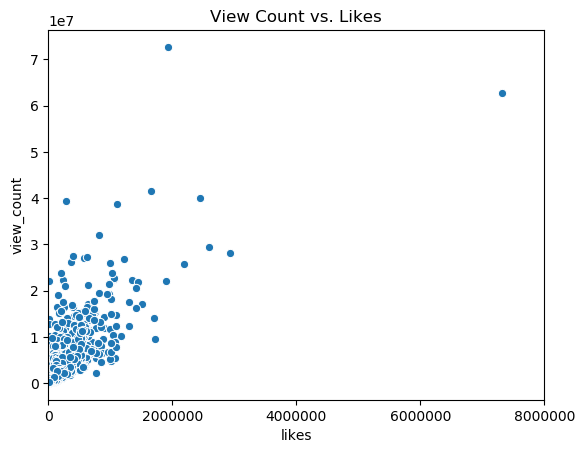

In [32]:
fig, ax = plt.subplots()

sns.scatterplot(data = us_gaming, x = "likes", y = "view_count", ax = ax)
plt.title("View Count vs. Likes")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

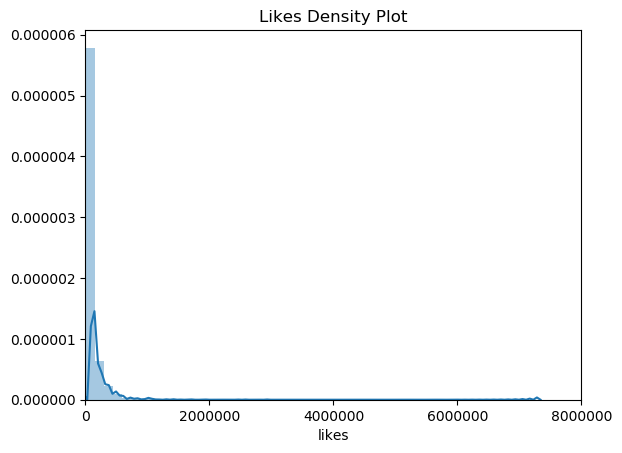

In [33]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

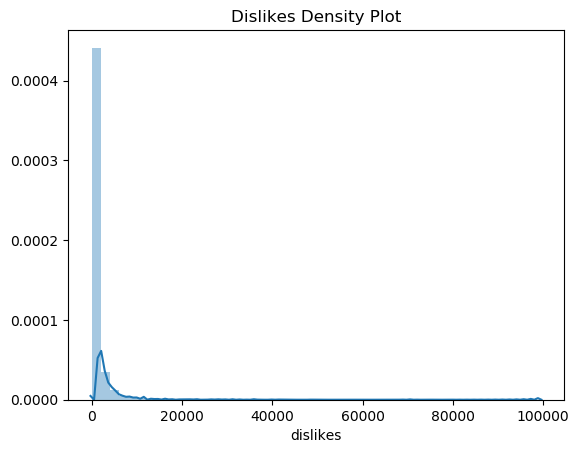

In [34]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

faze is a popular, legacy gaming brand at this point. Below the faze gaming organization 100t is charted as well, 100t is new gaming brand, although already find themselves very successful on YouTube. Looking at the comparison, faze, particularly prior to 2022, is the much stronger brand on YouTube, Perhaps when working out deals or collaborations with gaming brand with our creators, it would be more lucrative to attach our creators to faze's brand rather than 100t. 

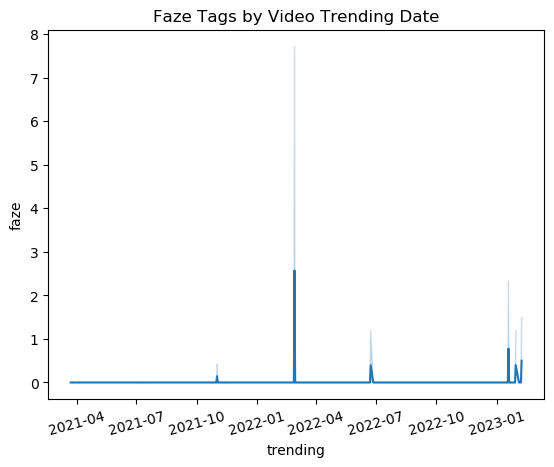

In [35]:
sns.lineplot(x = us_gaming["trending"], y = tag_df["faze"])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

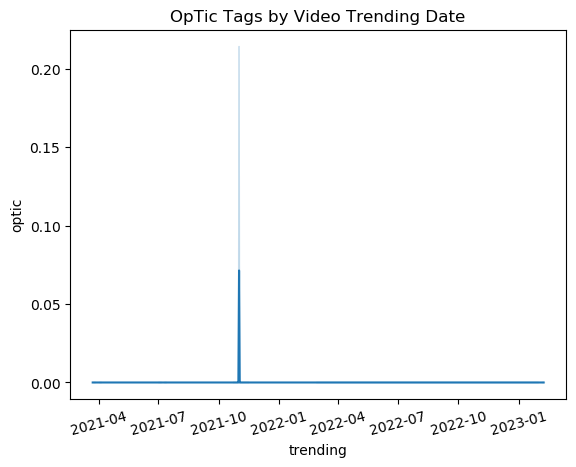

In [36]:
sns.lineplot(x = us_gaming['trending'], y = tag_df['optic'])
plt.xticks(rotation = 15)
plt.title("OpTic Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title. 

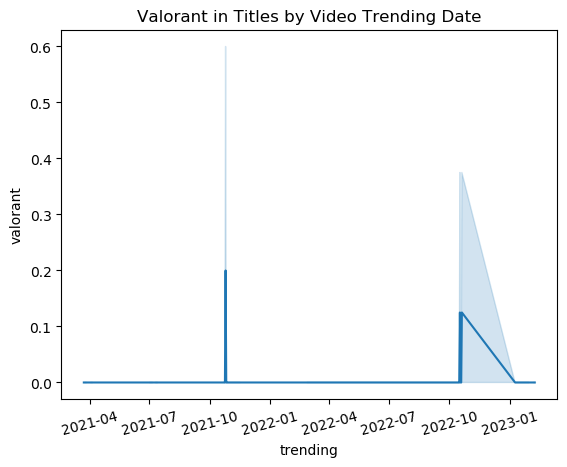

In [37]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

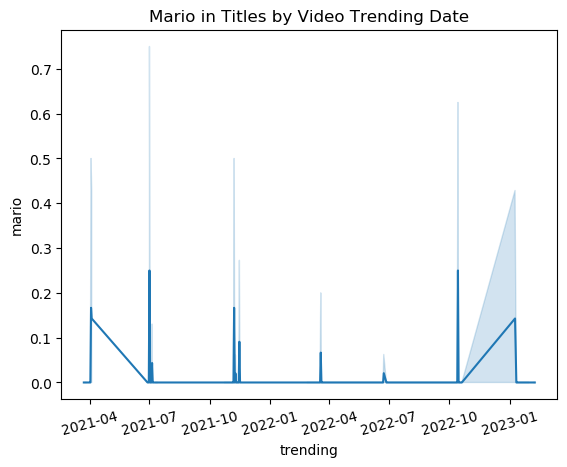

In [38]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()

### Feature Selection Final Decisions

Ultimately, as the goal of the project is to predict views, dislikes, likes, comment count, posting date, trending date, channelid, channel title, and thumbnail link cannot be used as predictors because we hope to predict the view count of the video before the video is posted. Perhaps in future projects an image recognition model can be used to predict views based upon thumbnail photos, but this project will be limited to text. Going forward, NLP techinques will be used to create a deep learning regression model from any combination of title, tags, and description in order to predict view count on videos as view count leads to greater growth for the creators. Particularly because, as the first scatterplot reveals above, high view count often lead to high likes which in turn leads to being boosted on the trending algorithm. The more eyes on the video, the more likely to trend. 

## Tokenization Transformations to Implement Deep Learning Modeling

Below is  a multi-step SKlearn processing container that will do the following:

1. Grab the gaming.csv from the s3 bucket where it was stored above. 

2. split the data using train/test/validation with 85/10/5 split

3. Commit the data to pre-processing transformations with distilBert and tensorflow. The data will be tokenized to extract ids and masks for title, tags, and description using distilbert. Then these ids and masks will be converted to tensorflow features and dataset in addition to view_count and video_id. This has been tracked using timestamps in the data column as well.

4. The newly transformed data is then stored in the output folder the output s3 bucket that is listed below.

In [39]:
# Timestamp the names of the different segments for tracking purposes over time.
timestamp = int(time.time())

# Creating the experiment for Youtube view count
experiment = Experiment.create(
    experiment_name="YouTube-View-Prediction-BERT-Experiment-{}".format(timestamp),
    description="YouTube View Prediction BERT Experiment",
    sagemaker_boto_client=sm,
)

# printing the experiment name
experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

Experiment name: YouTube-View-Prediction-BERT-Experiment-1680903826


In [40]:
# timestamp trial
timestamp = int(time.time())

# Creating trial using the experiment name and sagemaker
trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

# printing trial name
trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

Trial name: trial-1680903827


In [41]:
# store the trial name for later
%store trial_name

Stored 'trial_name' (str)


In [42]:
# setting the experiment configuration
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [43]:
# starting the feature store runtime within sagemaker
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [44]:
# timestamp prefix 
timestamp = int(time.time())

# setting the future store prefix for use in df-to-tokens-to-tensors.py file
feature_store_offline_prefix = "videos-feature-store-" + str(timestamp)

# print the full name of prefix
print(feature_store_offline_prefix)

videos-feature-store-1680903827


In [45]:
# create feature group name 
feature_group_name = "videos-feature-group-" + str(timestamp)

print(feature_group_name)

videos-feature-group-1680903827


In [46]:
# writing out our feature definitions to assign them to feature stores
# these definitions are for after the features have been transformed and prepped in addition to `date` that acts as the timestamp for the feature store
feature_definitions = [
    FeatureDefinition(feature_name="title_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="title_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="video_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="view_count", feature_type=FeatureTypeEnum.INTEGRAL),
]

In [47]:
# creating the feature group using the name and definition assigned above
feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=session)

print(feature_group)

FeatureGroup(name='videos-feature-group-1680903827', sagemaker_session=<sagemaker.session.Session object at 0x7f67fe12d950>, feature_definitions=[FeatureDefinition(feature_name='title_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='title_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='video_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEn

In [48]:
# setting the instance type and established our train/test/validation splits
# max_seq_length may need to be adjusted
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.85
validation_split_percentage = 0.05
test_split_percentage = 0.1
max_seq_length = 300

In [49]:
# creating the Sklearn processor to run the df-to-tokens-to-tensors.py file

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [50]:
# setting the processors inputs and outputs
processor.run(
    code="df-to-tokens-to-tensors.py",
    inputs=[
        ProcessingInput(
            input_name="gaming",
            source="s3://{}/youtubeStatistics/dfs/".format(bucket),
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", 
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation"
        ),
        ProcessingOutput(
            output_name="bert-test", 
            s3_upload_mode="EndOfJob", 
            source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2023-04-07-21-43-48-113


In [51]:
scikit_processing_job_name = processor.jobs[-1].describe()["ProcessingJobName"]
print(scikit_processing_job_name)

sagemaker-scikit-learn-2023-04-07-21-43-48-113


In [52]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name, sagemaker_session=session
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'gaming', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/youtubeStatistics/dfs/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/input/code/df-to-tokens-to-tensors.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'bert-train', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-train', 'LocalPath': '/opt/ml/processing/output/bert/train', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}, {'OutputName': 

In [53]:
# logs can be set to true to find errors when trouble shooting
running_processor.wait(logs=False)

...................................................................................................................................................................................!

In [54]:
# obtain the location of the new s3 folders for the training/testing/validation data in order to implement modeling
processing_job_description = running_processor.describe()

output_config = processing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "bert-train":
        processed_train_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-validation":
        processed_validation_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-test":
        processed_test_uri = output["S3Output"]["S3Uri"]

print(processed_train_uri)
print(processed_validation_uri)
print(processed_test_uri)

s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-train
s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-validation
s3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-test


This is the final transformation for the strings before modeling. The strings have been encoded/tokenized, placed into tensorflow tensors, made into a tensor dataset and ultimately transformed into a tensorflow dataset for modeling. The data has also been stored in the s3. 

## Model Creation/Training

Model creation and training will also be a script job that takes the tensors from the different folders within the s3 bucket to train and test the model within the script while revealing the results/progress here.

In [55]:
!aws s3 ls $processed_train_uri/

2023-04-07 21:58:50   15614710 part-algo-1-gaming.tfrecord


In [56]:
!aws s3 ls $processed_test_uri/

2023-04-07 21:58:50    1839428 part-algo-1-gaming.tfrecord


In [57]:
!aws s3 ls $processed_validation_uri/

2023-04-07 21:58:50     919252 part-algo-1-gaming.tfrecord


In [58]:
input_train_data = TrainingInput(processed_train_uri+"/", distribution="ShardedByS3Key")
input_validation_data = TrainingInput(s3_data=processed_validation_uri+"/", distribution="ShardedByS3Key")
input_test_data = TrainingInput(s3_data=processed_test_uri+"/", distribution="ShardedByS3Key")

print(input_train_data)
print(input_validation_data.config)
print(input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-validation/', 'S3DataDistributionType': 'ShardedByS3Key'}}}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-west-2-692349450615/sagemaker-scikit-learn-2023-04-07-21-43-48-113/output/bert-test/', 'S3DataDistributionType': 'ShardedByS3Key'}}}


In [59]:
epochs = 2
learning_rate = 0.001
epsilon = 0.000001
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_steps_per_epoch = 10
validation_steps = 10
test_steps = 10
train_instance_count = 1
train_instance_type = "ml.p2.xlarge"
train_volume_size = 1024
use_xla = True
use_amp = True
freeze_bert_layer = False
enable_sagemaker_debugger = True
enable_checkpointing = False
enable_tensorboard = True
input_mode = "Pipe"
run_validation = True
run_test = True
run_sample_predictions = True

In [60]:
metrics_definitions = [
    {"Name": "train:rmse", "Regex": "rmse: ([0-9\\.]+)"},
    {"Name": "train:mae", "Regex": "mae: ([0-9\\.]+)"},
    {"Name": "validation:rmse", "Regex": "rmse: ([0-9\\.]+)"},
    {"Name": "validation:mae", "Regex": "mae: ([0-9\\.]+)"},
]

In [61]:
actions = rule_configs.ActionList()

rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "save_interval": "10",  # number of steps
        "export_tensorboard": "true",
        "tensorboard_dir": "hook_tensorboard/",
    }
)

In [62]:
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10))

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [63]:
checkpoint_s3_prefix = "checkpoints/{}".format(str(uuid.uuid4()))
checkpoint_s3_uri = "s3://{}/{}/".format(bucket, checkpoint_s3_prefix)

print(checkpoint_s3_uri)

s3://sagemaker-us-west-2-692349450615/checkpoints/011d5585-1144-4434-8359-04affab51c89/


In [64]:
estimator = TensorFlow(
    entry_point="model_construction.py",
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    checkpoint_base_path=checkpoint_s3_uri,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "epsilon": epsilon,
        "train_batch_size": train_batch_size,
        "validation_batch_size": validation_batch_size,
        "test_batch_size": test_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "test_steps": test_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_test": run_test,
        "run_sample_predictions": run_sample_predictions,
    },
    input_mode=input_mode,
    metric_definitions=metrics_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [65]:
experiment_config = {"ExperimentName": experiment_name, "TrialName": trial_name, "TrialComponentDisplayName": "train"}

In [66]:
estimator.fit(
    inputs={"train": input_train_data, "validation": input_validation_data, "test": input_test_data},
    experiment_config=experiment_config,
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-04-07-21-58-59-945


In [67]:
training_job_name = estimator.latest_training_job.name
print("Training Job Name:  {}".format(training_job_name))

Training Job Name:  tensorflow-training-2023-04-07-21-58-59-945


In [68]:
%%time

estimator.latest_training_job.wait(logs=True)

2023-04-07 21:59:03 Starting - Starting the training job...
2023-04-07 21:59:27 Starting - Preparing the instances for trainingProfilerReport: InProgress
......
2023-04-07 22:00:27 Downloading - Downloading input data...
2023-04-07 22:01:05 Training - Downloading the training image...............
2023-04-07 22:03:26 Training - Training image download completed. Training in progress....2023-04-07 22:03:53.903755: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-04-07 22:03:53.903998: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 7
2023-04-07 22:03:53.904052: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2023-04-07 22:03:53.904063: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler/
2023-04-07 22:03:53.904079: I tens

UnexpectedStatusException: Error for Training job tensorflow-training-2023-04-07-21-58-59-945: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/local/bin/python3.7 model_construction.py --enable_checkpointing False --enable_sagemaker_debugger True --enable_tensorboard True --epochs 2 --epsilon 1e-06 --freeze_bert_layer False --learning_rate 0.001 --max_seq_length 300 --model_dir s3://sagemaker-us-west-2-692349450615/tensorflow-training-2023-04-07-21-58-59-945/model --run_sample_predictions True --run_test True --run_validation True --test_batch_size 32 --test_steps 10 --train_batch_size 32 --train_steps_per_epoch 10 --use_amp True --use_xla True --validation_batch_size 32 --validation_steps 10"
WARNING: You are using pip version 21.0.1; however, version 23.0.1 is available.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
WARNING: You are using pip version 21.0.1; however, version 23.0.1 is available.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
WARNING: You are using pip version 21.0.1;

In [69]:
estimator.training_job_analytics.dataframe()

""
